In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time
from munch import munchify
from FKMC.general import shapes 
from FKMC.plotting import spread

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [2]:
Ns = np.logspace(np.log10(70), np.log10(270), 10, dtype = np.int) // 10 * 10
Ns

array([ 70,  80,  90, 100, 120, 140, 170, 200, 230, 270])

## Random states, T = infinity

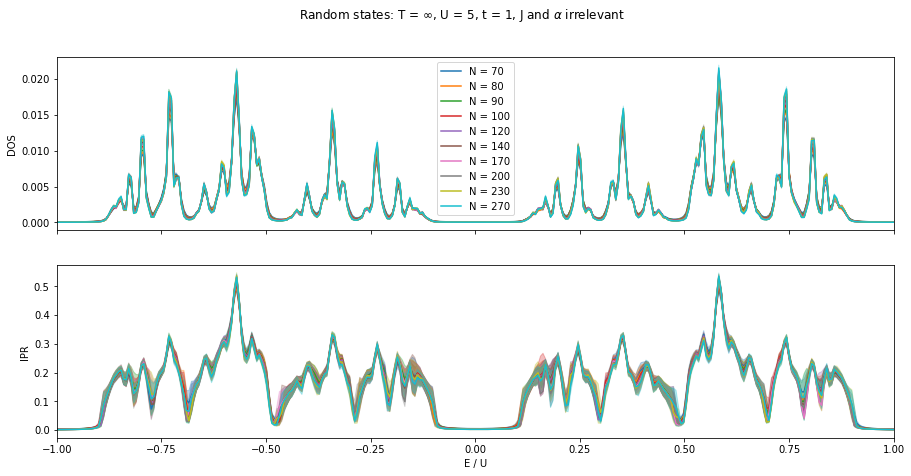

In [3]:
from shared_functions import solve_systems

N_states = int(1e5) # average over N_states // N replications
t = 1
U = 5

f, axes = plt.subplots(2,1, figsize = (15,7), sharex = 'col')

for N in Ns:
    M = N_states // N
    states = np.random.choice([1,0], size = (M,N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
    params = Munch(mu=0.0, beta = np.nan, U = U, t = t, N = N, alpha = 1.25, J = 1.0)
    energy_histogram_bins = np.linspace(-3*U, 3*U, 1000 + 1)

    DOS, IPR, dDOS, dIPR = solve_systems(states, params, energy_histogram_bins, scale = 10 / N)

    spread(axes[0], energy_histogram_bins[1:] / U, DOS, dDOS, label = f'N = {N}')
    spread(axes[1], energy_histogram_bins[1:] / U, IPR, dIPR)


f.suptitle(fr'Random states: T = $\infty$, U = {U}, t = {t}, J and $\alpha$ irrelevant')
axes[0].set(ylabel = 'DOS')    
axes[1].set(ylabel = 'IPR', xlim = (-1,1), xlabel = 'E / U')
axes[0].legend();

## Perfect CDW state

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


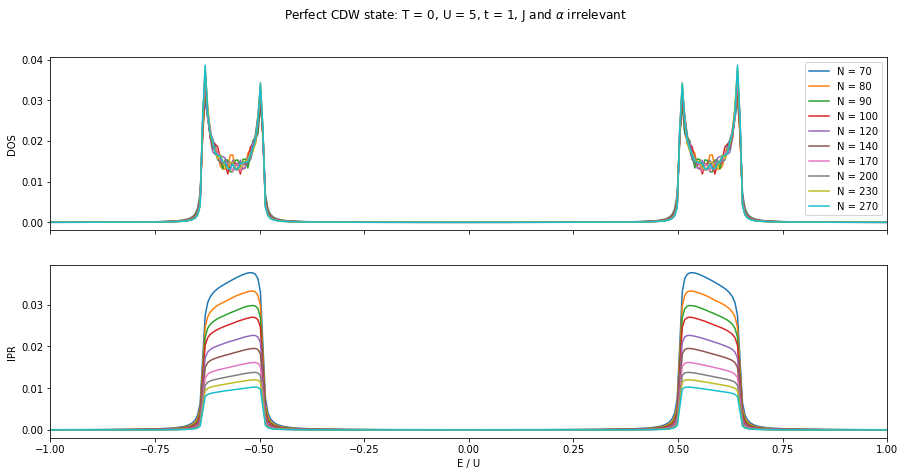

In [4]:
t = 1
U = 5

f, axes = plt.subplots(2,1, figsize = (15,7), sharex = 'col')

for N in Ns:
    alternating_sign = 2*(np.arange(N) % 2) - 1
    states = (alternating_sign + 1) // 2
    states.shape = (1, N)
    
    params = Munch(mu=0.0, beta = np.nan, U = U, t = t, N = N, alpha = 1.25, J = 1.0)
    energy_histogram_bins = np.linspace(-3*U, 3*U, 1000 + 1)

    DOS, IPR, dDOS, dIPR = solve_systems(states, params, energy_histogram_bins, scale = 10 / N)

    spread(axes[0], energy_histogram_bins[1:] / U, DOS, dDOS, label = f'N = {N}')
    spread(axes[1], energy_histogram_bins[1:] / U, IPR, dIPR)


f.suptitle(fr'Perfect CDW state: T = 0, U = {U}, t = {t}, J and $\alpha$ irrelevant')
axes[0].set(ylabel = 'DOS')    
axes[1].set(ylabel = 'IPR', xlim = (-1,1), xlabel = 'E / U')
axes[0].legend();

In [18]:
a = np.arange(5)
b = a[None, :] * np.ones(shape = (3,5))
b[1, [0,2]] = -b[1, [0,2]]
b

array([[ 0.,  1.,  2.,  3.,  4.],
       [-0.,  1., -2.,  3.,  4.],
       [ 0.,  1.,  2.,  3.,  4.]])

## Energy cost of defects from the CDW background

This code takes the CDW background and gives it k random defects.

In [137]:
#graph the average energy of k random spin flips
from FKMC.general import interaction_matrix, solve_H_vectorised

t = 1
U = 5
J = 5
M = 20
Ns = np.logspace(np.log10(70), np.log10(270), 5, dtype = np.int) // 10 * 10
defect_density = np.linspace(0, 0.5, 20)

params = Munch(mu=0.0, beta = 1/1.5, U = U, t = t, N = N, alpha = 1.25, J = J)
energy_histogram_bins = np.linspace(-3*U, 3*U, 1000 + 1)


Ff, Fc, dFf, dFc = np.zeros(shape = (4, len(Ns), len(defect_density)))

for i,N in enumerate(Ns):
    params.N = N
    params.J_matrix = interaction_matrix(**params)
    for j,d in enumerate(defect_density):
        k = np.int(N * d)#calculate the necessary number of defects
        
        alternating_sign = 2*(np.arange(N) % 2) - 1
        states = alternating_sign[None, :] * np.ones(shape = (M, N))
        
        
        for l in range(M):
            flips = np.random.choice(np.arange(N), size = (k,), replace=False)
            states[l, flips] = -states[l, flips] 
        
        states = (states + 1) // 2

        Ffi, Fci, eigenvals, eigenvecs = solve_H_vectorised(states, **params)
        Ff[i,j] = np.mean(Ffi)
        Fc[i,j] = np.mean(Fci)
        
        dFf[i,j] = np.max(Ffi) - np.min(Ffi)
        dFc[i,j] = np.max(Fci) - np.min(Fci)
        

Text(0.3, 0.1, 'Spread indicates min/max')

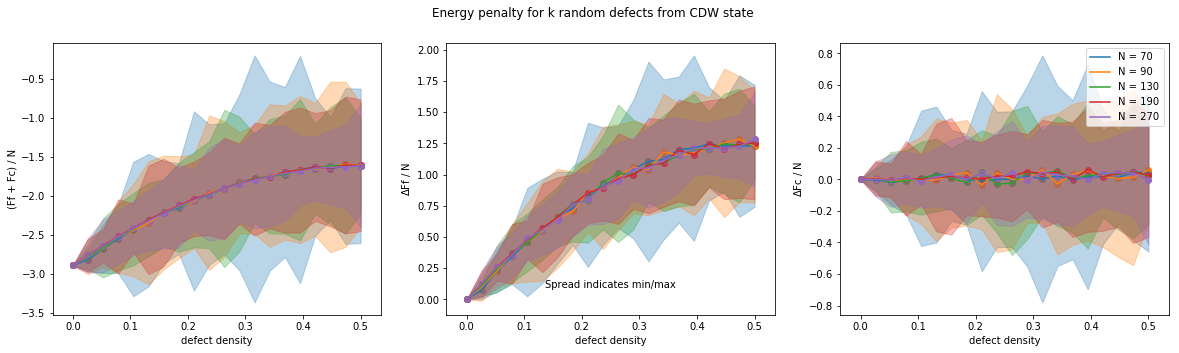

In [149]:
f, axes = plt.subplots(1,3, figsize = (20,5))

for i,N in enumerate(Ns):
    X = defect_density
    
    Y = (Ff[i, :] + Fc[i, :]) / N
    dY = (dFf[i, :] + dFc[i, :]) / N
    axes[0].set(xlabel = 'defect density', ylabel = '(Ff + Fc) / N')
    axes[0].scatter(X, Y, label = f'')
    spread(axes[0], X, Y, dY, label = f'N = {N}')
    
    X = defect_density
    Y = (Ff[i, :] - Ff[i, 0]) / N
    dY = dFf[i, :] / N
    axes[1].set(xlabel = 'defect density', ylabel = '$\Delta$Ff / N')
    axes[1].scatter(X, Y, label = f'N = {N}')
    spread(axes[1], X, Y, dY, label = f'N = {N}')
    
    Y = (Fc[i, :] - Fc[i, 0]) / N
    dY = dFc[i, :] / N
    axes[2].set(xlabel = 'defect density', ylabel = '$\Delta$Fc / N')
    axes[2].scatter(X, Y)
    spread(axes[2], X, Y, dY, label = f'N = {N}')
    
    #axes[3].set(ylim = axes[2].get_ylim())

f.suptitle('Energy penalty for k random defects from CDW state')


axes[2].legend()
axes[1].text(0.3,0.1,'Spread indicates min/max', transform=axes[1].transAxes)

## Dirty CDW state (CDW state with uncorrelated chance of flips)

In [200]:
with open(f'/workspace/tch14/pickled_data/local_runs_processed_smoothed_june2.pickle', 'rb') as file: 
    data = pickle.load(file)
    print(data.keys())

dict_keys([0, 1, 2])


In [207]:
o = Munch()
o.Ns = data[1].Ns
o.parameters = o.params = data[1].parameters
o.M = int(1e3) # average over this many replications

msquared = data[1].Mf_moments[-1, :, 2].mean()
o.p = np.sqrt(1 - msquared)
print(f'p = {o.p*100:.0f}') #the probability of a deviation from the CDW

o.E_bins = data[1].E_bins
o.DOS, o.IPR, o.dDOS, o.dIPR = np.zeros(shape = (4, len(o.Ns), len(o.E_bins)-1))

for i,N in enumerate(o.Ns):
    alternating_sign = 2*(np.arange(N) % 2) - 1
    flips = np.random.choice(a = [-1,1], size = (M, N), p = [p, 1-p])
    global_sign = np.random.choice(a = [-1,1], size = (M, 1))
    
    o.parameters.N = N
    states = (alternating_sign * flips + 1) // 2

    o.DOS[i], o.IPR[i], o.dDOS[i], o.dIPR[i] = solve_systems(states, o.parameters, o.E_bins, scale = 10 / N)
    
dirtyCDW = o  

p = 44


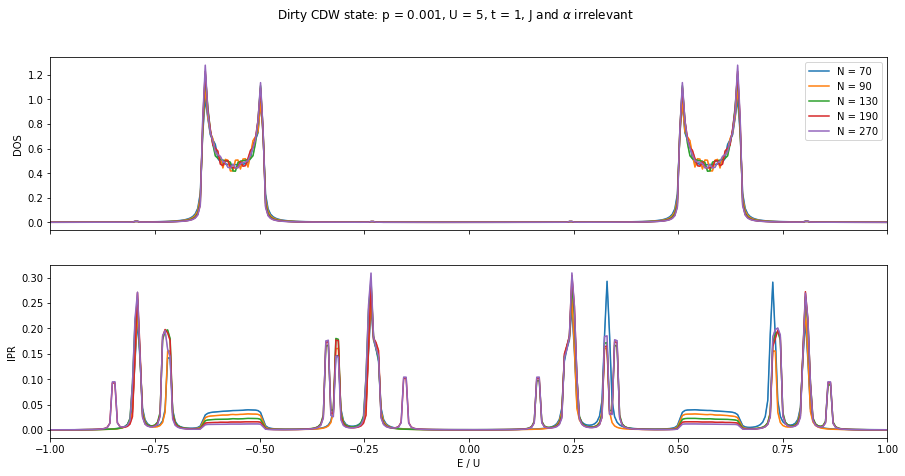

In [195]:
f, axes = plt.subplots(2,1, figsize = (15,7), sharex = 'col')
o = dirtyCDW
for i,N in enumerate(o.Ns):
    idx = o.DOS[i] < 5e-5
    _DOS = o.DOS[i].copy()
    _IPR = o.IPR[i].copy()

    _DOS[idx] = np.nan
    _IPR[idx] = np.nan

    spread(axes[0], energy_histogram_bins[1:] / o.params.U, _DOS, o.dDOS[i], label = f'N = {N}')
    spread(axes[1], energy_histogram_bins[1:] / o.params.U, _IPR, o.dIPR[i])


f.suptitle(fr'Dirty CDW state: p = {p}, U = {U}, t = {t}, J and $\alpha$ irrelevant')
axes[0].set(ylabel = 'DOS')    
axes[1].set(ylabel = 'IPR', xlim = (-1,1), xlabel = 'E / U')
axes[0].legend();

Text(0.5, 0.98, '\nReal: T = 1.5, J = 5, U = 5, M**2 = 0.81\n')

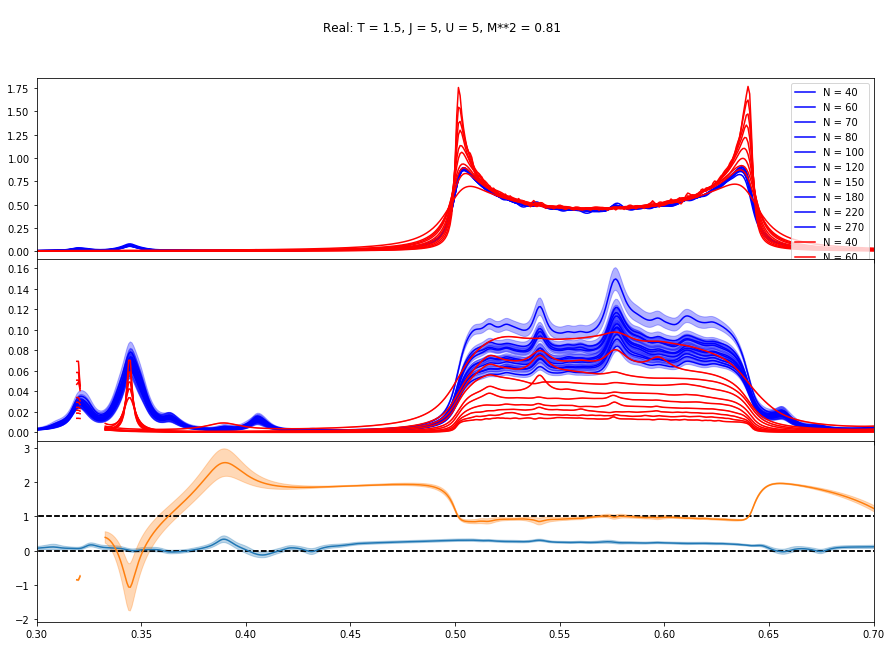

In [205]:
from FKMC.plotting import plot_scaling_dimension
o = data[1]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001,
                    colors = ['b',] * 10,)

plot_scaling_dimension(axes = axes,
                       original_data = dirtyCDW,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001,
                      colors = ['r',] * 10,)

axes[0].legend()
axes[0].set(xlim = (0.3, 0.7))
f.suptitle(f'''
Real: T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}
''')